Importar librerias requeridas

In [1]:
import ee 
import geemap
import json
import os
import pandas as pd
import matplotlib.pyplot as plt


Autenticación con GEE y extracción de zona de estudio

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-rimartinezs')

In [3]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Voronoi_Poligons_Usme.geojson')) as geojson:
    data = json.load(geojson)

zona_estudio = ee.FeatureCollection(data)

Calculo del NDVI

In [ ]:
# Colección Sentinel-2
s2Col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(zona_estudio) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) \
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

# Crear mosaico diario
def mosaic_per_date(date):
    start = ee.Date(date)
    end = start.advance(1, 'day')
    daily = s2Col.filterDate(start, end).mosaic()
    return daily.set('system:time_start', start.millis())

# Lista de fechas únicas (formato YYYY-MM-dd)
dates = s2Col.aggregate_array('system:time_start').distinct()
dates = dates.map(lambda d: ee.Date(d).format('YYYY-MM-dd'))

# Crear colección de mosaicos
mosaic_collection = ee.ImageCollection(dates.map(lambda d: mosaic_per_date(d)))

# Recortar imágenes
def recortar(img):
    return img.clip(zona_estudio)
aoi_S2c = mosaic_collection.map(recortar)

# Rescalar imágenes
escala = 0.0001
def rescalar(img):
    bands = img.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])
    scaled = bands.multiply(escala)
    return scaled.copyProperties(img, img.propertyNames())
aoi_S2r = aoi_S2c.map(rescalar)

# Calcula NDVI
def calcNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi).copyProperties(image, image.propertyNames())
s2Ndvi = aoi_S2r.map(calcNDVI)

# Imagen con menos nubes (puedes mantenerlo si quieres visualizarlo)
un_Ndvi = s2Ndvi.sort('CLOUDY_PIXEL_PERCENTAGE').first()

# Seleccionar solo la banda NDVI
NDVIcol = s2Ndvi.select('NDVI')

# Promedio de NDVI por fecha y polígono
def extraer_promedios(img):
    stats = img.reduceRegions(
        collection=zona_estudio,
        reducer=ee.Reducer.mean(),
        scale=10  # Sentinel-2 tiene resolución de 10 m en B4 y B8
    )
    stats = stats.map(lambda f: f.set('system:time_start', img.get('system:time_start')))
    return stats

ndvi_stats = NDVIcol.map(extraer_promedios).flatten()

# Convertir a lista
features = ndvi_stats.getInfo()['features']

# Procesar a DataFrame
rows = []
for f in features:
    props = f['properties']
    # Obtener fecha como timestamp, convertir a formato legible
    date = pd.to_datetime(props['system:time_start'], unit='ms').strftime('%Y-%m-%d')
    rows.append({
        'id': props.get('rand_point_id'),  # Usa el nombre correcto según tu tabla
        'date': date,
        'NDVI_mean': props.get('mean')
    })

df = pd.DataFrame(rows)
df['date'] = pd.to_datetime(df['date'])

print(df)


     id       date  NDVI_mean
0    14 2023-01-28   0.458099
1    16 2023-01-28   0.463028
2    17 2023-01-28   0.615565
3    12 2023-01-28   0.399568
4    22 2023-01-28   0.561334
..   ..        ...        ...
995   1 2023-12-29   0.215664
996  19 2023-12-29   0.189839
997  10 2023-12-29   0.144897
998  23 2023-12-29   0.268447
999  20 2023-12-29   0.325600

[1000 rows x 3 columns]


Grafico del NDVI

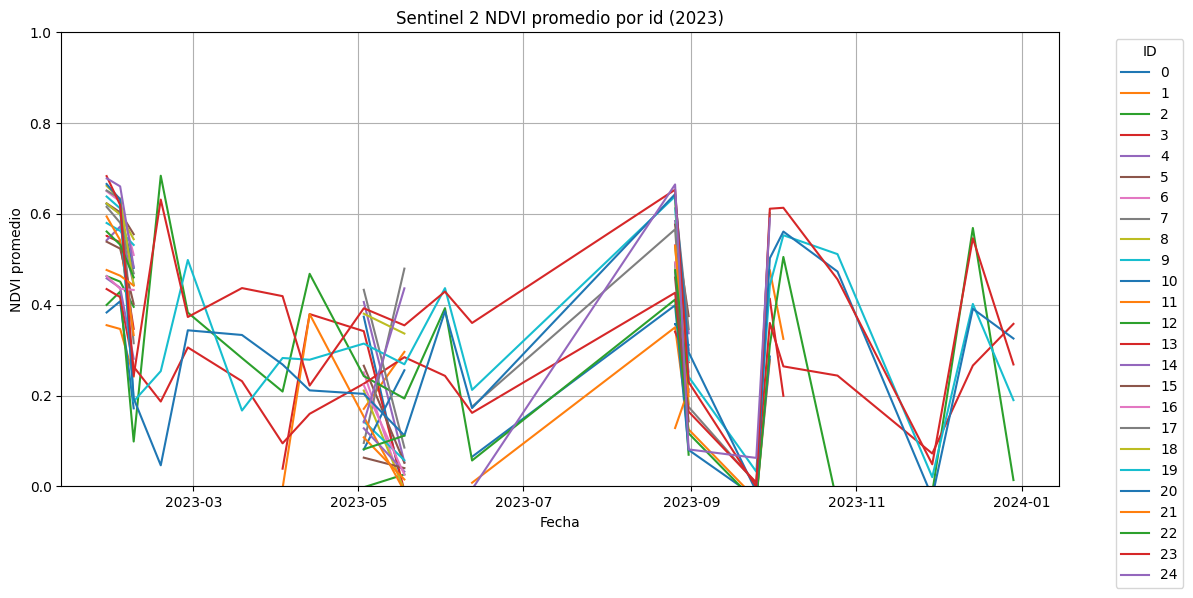

In [14]:
plt.figure(figsize=(12,6))
for key, grp in df.groupby('id'):
    plt.plot(grp['date'], grp['NDVI_mean'], label=str(key))
plt.title('Sentinel 2 NDVI promedio por id (2023)')
plt.xlabel('Fecha')
plt.ylabel('NDVI promedio')
plt.ylim(0,1)
plt.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



Mapa del NDVI

In [12]:
ndvi_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
                '74A901', '66A000', '529400', '3E8601', '207401', '056201',
                '004C00', '023B01', '012E01', '011D01', '011301']

Map = geemap.Map()
Map.centerObject(zona_estudio, 10)
Map.addLayer(zona_estudio, {}, 'Localidad de Usme')
Map.addLayer(un_Ndvi.select('NDVI'), {'min': 0, 'max': 1, 'palette': ndvi_palette}, 'NDVI')
Map 

Map(center=[4.390019031052541, -74.14281202673838], controls=(WidgetControl(options=['position', 'transparent_…